#### Import Statements

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy

import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Download data
training_data = datasets.FashionMNIST(
    root='data', 
    train=True, 
    download=True, 
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data', 
    train=False, 
    download=True, 
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Shape of X [N, C, H, W]:  torch.Size([128, 1, 28, 28])
Shape of Y:  torch.Size([128])


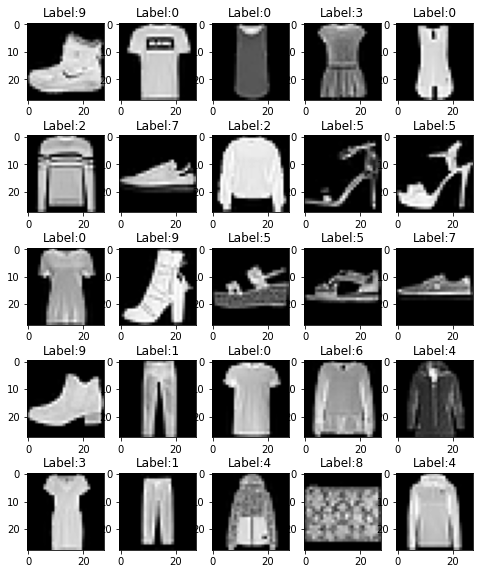

In [ ]:
batch_size=128

# Create data loader
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# load one batch of training data
for data in train_dataloader:
  break

x = data[0]
y = data[1]
print('Shape of X [N, C, H, W]: ', x.shape)
print('Shape of Y: ', y.shape)

plt.figure(figsize=(8,10))
for i in range(25): 
  plt.subplot(5,5,i+1)
  plt.imshow(x[i,0,:,:], cmap="gray")
  plt.title("Label:%i" %y[i])

#### Define MLP Modelrs
The model will have three layers
- Input layer shape: 28X28X1
- Hidden layer shape: 512
- Output layer shape: 10

In [ ]:
class MLP(nn.Module):
  # struture of the model
  def __init__(self):
    super(MLP, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        # first layer
        nn.Linear(28*28, 512),
        # non-linear activation
        nn.ReLU(), 
        # 2nd layer
        nn.Linear(512,512), 
        nn.ReLU(),
        # 3rd layer
        nn.Linear(512, 10)
    )
    
  # data passing flow
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

#### Define the Training Operation
- Normally, we train a NN in multiple epochs
  - Epoch: the model sees the entire training data once
- For training, we need: 
  - NN model
  - Loss Function (cost)
  - Optimizer (e.g., gradient descent)
- Tasks for one training step (i.e., batch)
  - Load one batch
  - Pass the batch through the model
  - Get the model output
  - Compute the cost (i.e., loss or prediction error)
  - Backpropagation 
  

In [ ]:
def train(dataloader, model, loss_fn, optimizer, device):
  model.train() # set model to train model
  for step, (x, y) in enumerate(dataloader): 
    # send data to GPU or CPU
    x = x.to(device)
    y = y.to(device)
    
    # feed the data to the model
    pred = model(x)
    
    # compute the loss
    loss = loss_fn(pred, y)
    
    # backpropagation (update the parameters)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 100 == 0: 
      loss  = loss.item()
      print('Current Step: %d, loss:%.4f' %(step, loss))

In [ ]:
def test(dataloader, model, loss_fn, device):
  num_batch = len(dataloader)

  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device)
      pred = model(x)
      loss = loss_fn(pred, y)
      test_loss += loss.item()
      
      y_hat = pred.argmax(1)
      correct_batch = (y_hat == y).type(torch.float).sum().item()
      correct += correct_batch
  test_loss /= num_batch
  correct = correct / (num_batch * batch_size)

  print("Test Accuracy:%.4f" % correct)


In [ ]:
# get CPU or GPU for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using %s device" %device)

# create the model
model = MLP().to(device)
print(model)

# optimizing the model parameter
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# train the model in epochs
epochs = 5
for t in tqdm.tqdm(range(epochs)):
  print("Epoch %d \n----------------------" %t)
  train(train_dataloader, model, loss_fn, optimizer, device)
  test(test_dataloader, model, loss_fn, device)
print("Done!")



Using cpu device
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 
----------------------
Current Step: 0, loss:2.2999
Current Step: 100, loss:2.2911
Current Step: 200, loss:2.2778
Current Step: 300, loss:2.2652
Current Step: 400, loss:2.2469


 20%|██        | 1/5 [00:19<01:16, 19.23s/it]

Test Accuracy:0.3907
Epoch 1 
----------------------
Current Step: 0, loss:2.2321
Current Step: 100, loss:2.2150
Current Step: 200, loss:2.2058
Current Step: 300, loss:2.1961
Current Step: 400, loss:2.1653


 40%|████      | 2/5 [00:34<00:50, 16.93s/it]

Test Accuracy:0.4882
Epoch 2 
----------------------
Current Step: 0, loss:2.1504
Current Step: 100, loss:2.1186
Current Step: 200, loss:2.1096
Current Step: 300, loss:2.0979
Current Step: 400, loss:2.0525


 60%|██████    | 3/5 [00:50<00:32, 16.46s/it]

Test Accuracy:0.5088
Epoch 3 
----------------------
Current Step: 0, loss:2.0311
Current Step: 100, loss:1.9795
Current Step: 200, loss:1.9690
Current Step: 300, loss:1.9509
Current Step: 400, loss:1.8984


 80%|████████  | 4/5 [01:06<00:16, 16.39s/it]

Test Accuracy:0.5291
Epoch 4 
----------------------
Current Step: 0, loss:1.8624
Current Step: 100, loss:1.7914
Current Step: 200, loss:1.7820
Current Step: 300, loss:1.7575
Current Step: 400, loss:1.7148


100%|██████████| 5/5 [01:22<00:00, 16.41s/it]

Test Accuracy:0.5592
Done!


#### Training Results
- Model 1 (512, 512, 10)
  - Training time: 1 minute 49 seconds
  - Accuracy: 56%

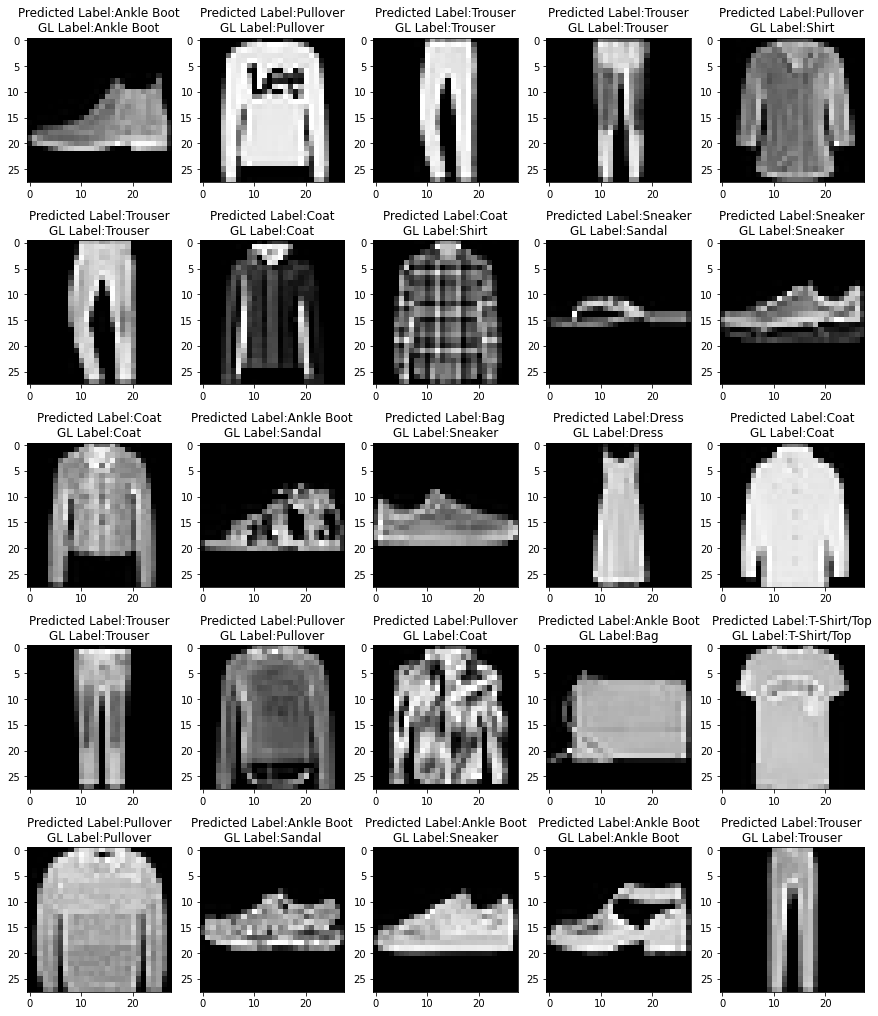

In [ ]:
# visualize the testing result
classes = [
    "T-Shirt/Top", 
    "Trouser",
    "Pullover", 
    "Dress", 
    "Coat", 
    "Sandal", 
    "Shirt", 
    "Sneaker", 
    "Bag", 
    "Ankle Boot",
]

model.eval()
for x, y in test_dataloader:
  x = x.to(device)
  y = y.to(device)
  with torch.no_grad(): 
    pred = model(x)
    pred_labels = pred.argmax(1)
  break

plt.figure(figsize=(15,18))
for i in range(25): 
  y_hat = pred_labels[i].item()
  y_gt = y[i].item()
  plt.subplot(5,5,i+1)
  plt.imshow(x[i,0,:,:].cpu().numpy(), cmap="gray")
  plt.title('Predicted Label:%s\nGL Label:%s' %(classes[y_hat], classes[y_gt]))